# Encoding Logical Qubits

We follow a procedure outlined in ___ to encode a logical qubit using elementary gates

In [505]:
%pip install qiskit qiskit_aer pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [502]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt

# Encoding Logical Zero
We begin by encoding logical qubits for the 5 qubit error correcting code. We follow the construction given in "Implementation and Analysis of Stabilizer Codes in pyQuil" by Chandak, Mardia, and Tolunay, with one slight modification (a starting Z gate in the bottom-most qubit) in order to get the phase correct. This circuit, given an initial state $\psi$ in the top-most qubit and zeros elsewhere, will output $|\psi\rangle_L$.  Thus, the output of this circuit currently is just
$$|0\rangle_L = \frac{1}{4}\left(|00000\rangle  + |10010\rangle + |01001\rangle + |10100\rangle + |01010\rangle - |11011\rangle - |00110\rangle - |11000\rangle - |11101\rangle - |00011\rangle - |11110\rangle - |01111\rangle - |10001\rangle - |01100\rangle - |10111\rangle + |00101\rangle\right)$$

In [539]:
def logical_state_encoder(starting_state):
    """
    This encodes either logical 0 or logical 1 for the five qubit error correcting code

    Inputs
    ------
    starting_state (int): Must be 0 or 1. This is the logical qubit we hope to encode

    Outputs
    -----
    A quantum circuit for which the statevector is logical 0 or 1, depending on starting_state
    """
    
    
    qubits_for_code = QuantumRegister(size = 5, name="5-qubit")
    
    five_qubit_prep_circuit = QuantumCircuit(qubits_for_code, name = "5 qubit code")
    
    if starting_state == 1:
        five_qubit_prep_circuit.x(qubits_for_code[4])
    five_qubit_prep_circuit.z(qubits_for_code[4])
    
    five_qubit_prep_circuit.h(qubits_for_code[0])
    five_qubit_prep_circuit.s(qubits_for_code[0])
    five_qubit_prep_circuit.cz(qubits_for_code[0],qubits_for_code[1])
    five_qubit_prep_circuit.cz(qubits_for_code[0],qubits_for_code[3])
    five_qubit_prep_circuit.cy(qubits_for_code[0],qubits_for_code[4])
    
    five_qubit_prep_circuit.h(qubits_for_code[1])
    five_qubit_prep_circuit.cz(qubits_for_code[1],qubits_for_code[2])
    five_qubit_prep_circuit.cz(qubits_for_code[1],qubits_for_code[3])
    five_qubit_prep_circuit.cx(qubits_for_code[1],qubits_for_code[4])
    
    five_qubit_prep_circuit.h(qubits_for_code[2])
    five_qubit_prep_circuit.cz(qubits_for_code[2],qubits_for_code[1])
    five_qubit_prep_circuit.cz(qubits_for_code[2],qubits_for_code[0])
    five_qubit_prep_circuit.cx(qubits_for_code[2],qubits_for_code[4])
    
    five_qubit_prep_circuit.h(qubits_for_code[3])
    five_qubit_prep_circuit.s(qubits_for_code[3])
    five_qubit_prep_circuit.cz(qubits_for_code[3],qubits_for_code[2])
    five_qubit_prep_circuit.cz(qubits_for_code[3],qubits_for_code[0])
    five_qubit_prep_circuit.cy(qubits_for_code[3],qubits_for_code[4])
    
    return five_qubit_prep_circuit

In [434]:
#To (partially) validate this gives the correct set of qubits, we can examine which basis vectors are in the resulting vector
#Some computation shows that this is indeed correct
print(np.where(Statevector(logical_state_encoder(0)).data)[0])

[ 0  3  5  6  9 10 12 15 17 18 20 23 24 27 29 30]


# Adding Errors
In order to test quantum error correction, we also need to add random errors and then evaluate the success of our code. We want to add a random Pauli error with probability $p$ to each qubit. This function outputs a circuit that randomly does this for any number of qubits and any probability

In [540]:
def error_channel(n, prob):
    """
    This outputs a circuit which introduces a single gate error with a given probability on any number of qubits

    Inputs
    -----
    n (int): The number of qubits
    prob (float): the probability of an error

    Outputs
    -------
    A quantum circuit with up to one (per qubit) randomly chosen single gate.
    """
    
    qubits = QuantumRegister(size=n, name = "")
    qc = QuantumCircuit(qubits,name="Error Channel")
    #Go through each qubit and randomly assign an error
    for i in range(n):
        error_check = np.random.rand()
        #Each possible qubit error happens with probability prob/3
        if error_check < prob/3:
            qc.x([i])
        elif error_check < 2*prob/3:
            qc.y([i])
        elif error_check < prob:
            qc.z([i])
    return qc
            

One possible output of this is the following.

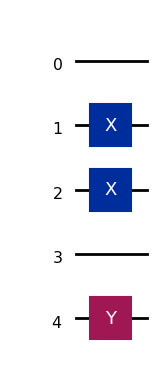

In [538]:
error_channel(5,0.3).draw(output="mpl")

# Adding Syndromes

The syndromes for the five qubit code are given by
\begin{align*}
S_1 &= XZZX1\\
S_2 &= 1XZZX\\
S_3 &= X1XZZ\\
S_4 &= ZX1XZ
\end{align*}

We now encode these checks into the circuit, going one syndrome at a time.

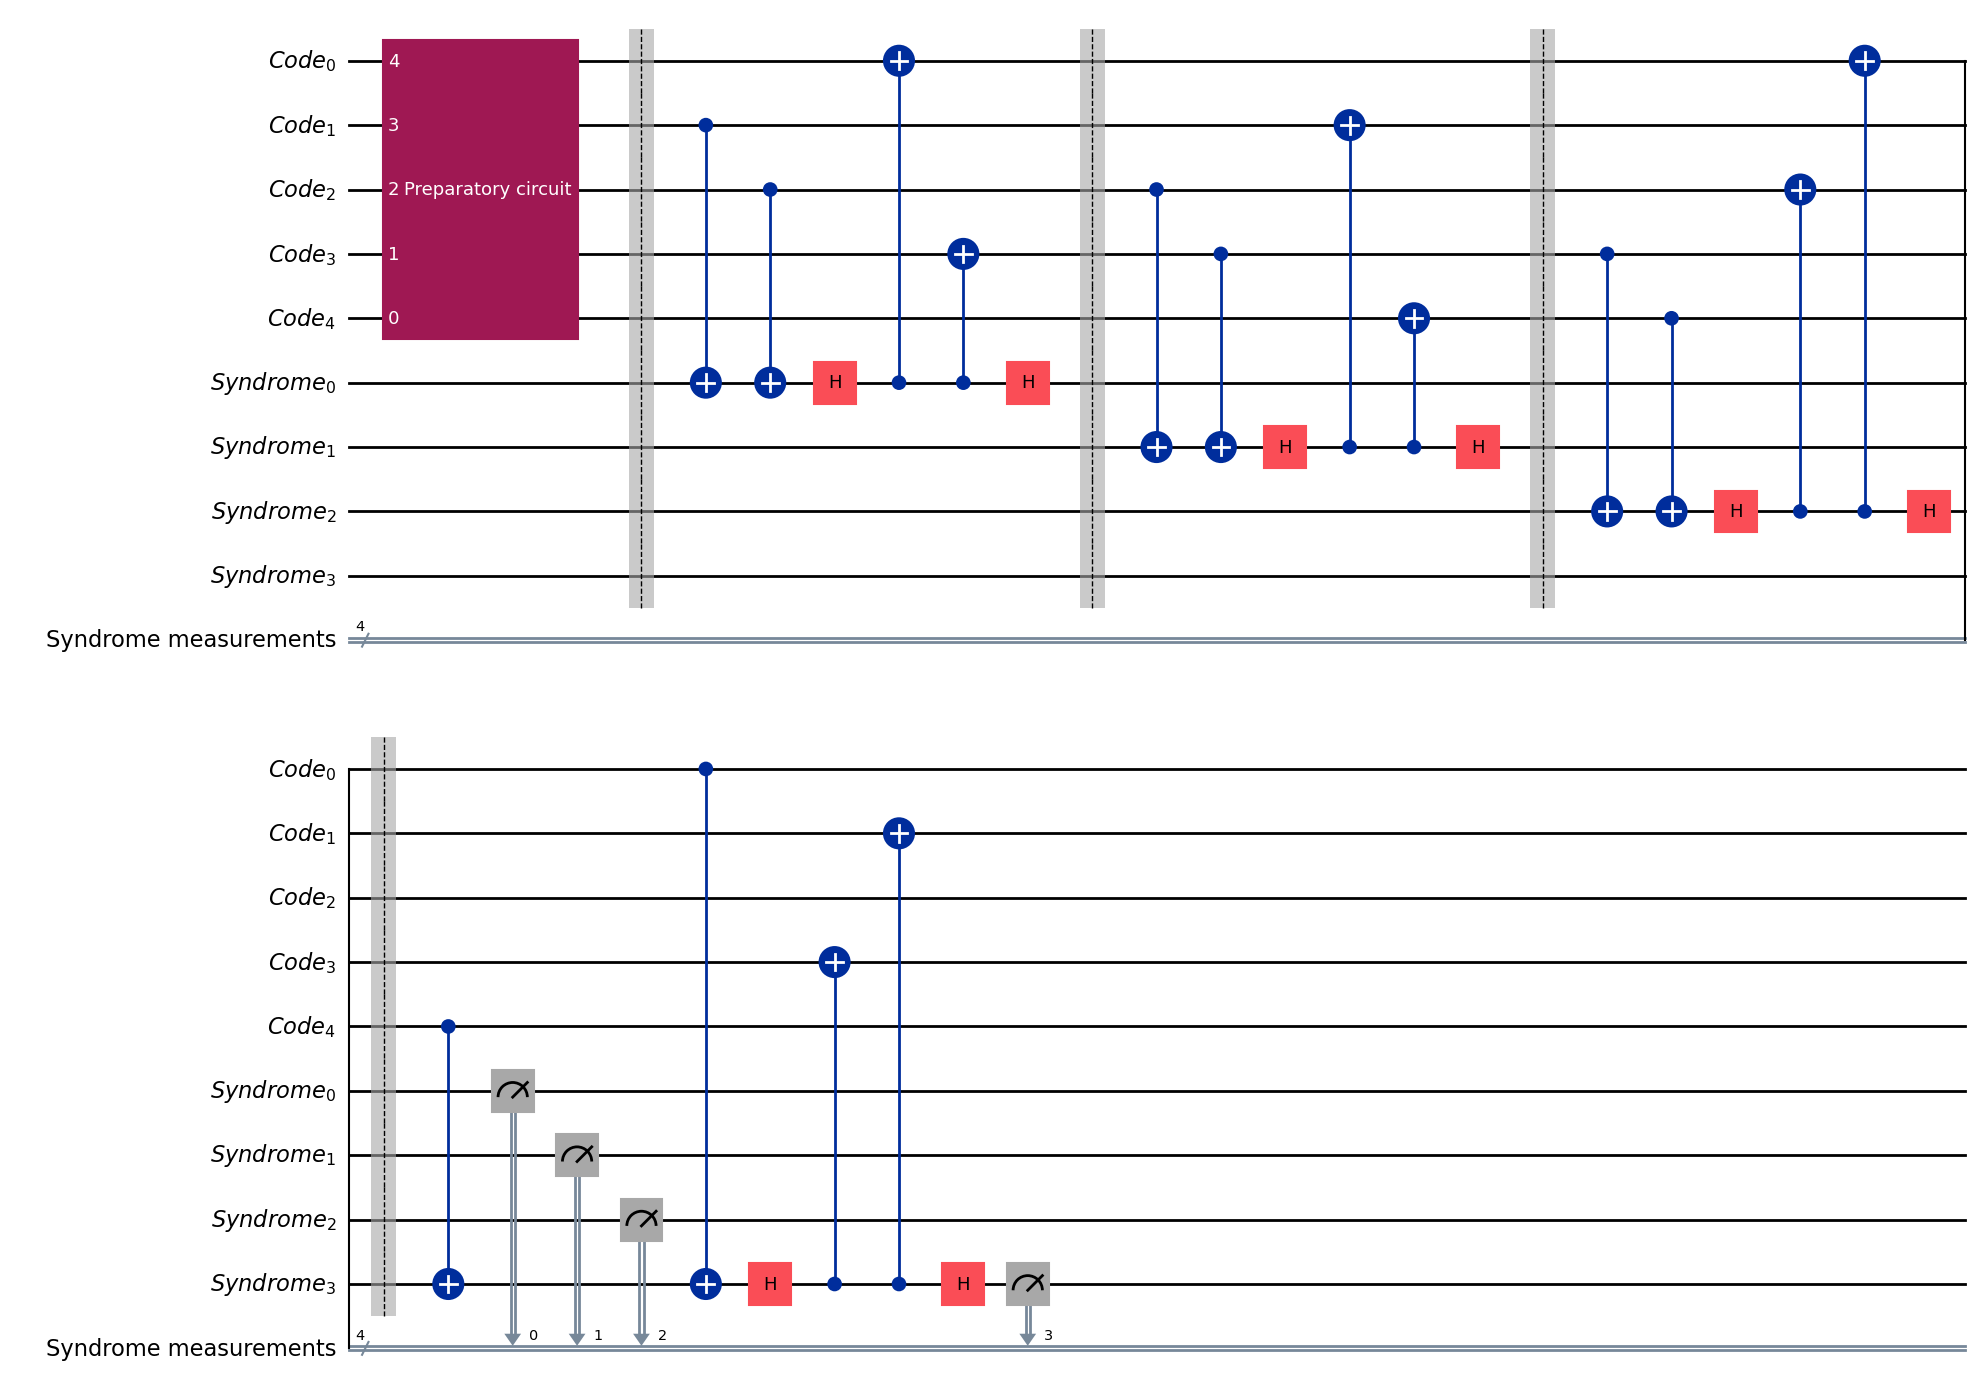

In [382]:
five_qubit_prep = logical_state_encoder(0).to_gate()
five_qubit_prep.label = "Preparatory circuit"

qubits_for_code = QuantumRegister(size=5,name="Code")
qubits_for_syndromes = AncillaRegister(size=4,name="Syndrome")
Syndrome_Measurements = ClassicalRegister(size=4,name="Syndrome measurements")
five_code_circuit = QuantumCircuit(qubits_for_code, qubits_for_syndromes, Syndrome_Measurements, name = "Five Qubit Code")

#We prepare a logical qubit using our preparatory circuit
five_code_circuit.compose(five_qubit_prep, qubits=[4,3,2,1,0], inplace=True)


#We now check each syndrome, going one at a time doing the X checks first, and then the Z checks.
#Each syndrome has X checks separated by 3 qubits and consecutive Z checks, allowing us to use a for loop to iterate through them

for i in range(4):
    five_code_circuit.barrier()
    five_code_circuit.cx(qubits_for_code[i+1],qubits_for_syndromes[i])
    five_code_circuit.cx(qubits_for_code[(i+2)%5],qubits_for_syndromes[i])
    five_code_circuit.h(qubits_for_syndromes[i])
    five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[i])
    five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[(i+3)%5])
    five_code_circuit.h(qubits_for_syndromes[i])
    

#We now measure the syndromes, and in doing so, identify any errors that have arisen.

five_code_circuit.measure(qubits_for_syndromes,Syndrome_Measurements)

five_code_circuit.draw(output="mpl")

# Finding Fixes
To find a fix for a given syndrome output, we simply introduce a single gate error to the above circuit, and record the syndrome measurement in that particular case. We provide an example of this procedure for X-gate errors below.

In [436]:
five_qubit_prep = logical_state_encoder(0).to_gate()
five_qubit_prep.label = "Preparatory circuit"

for i in range(5):
    print("X error in qubit",i)
    five_code_circuit = QuantumCircuit(qubits_for_code, qubits_for_syndromes, Syndrome_Measurements, name = "Five Qubit Code")
    
#We prepare a logical qubit using our preparatory circuit
    five_code_circuit.compose(five_qubit_prep, qubits=[4,3,2,1,0], inplace=True)

    five_code_circuit.x([i])

#We now check each syndrome, going one at a time doing the X checks first, and then the Z checks.
#Each syndrome has X checks separated by 3 qubits and consecutive Z checks, allowing us to use a for loop to iterate through them

    for i in range(4):
        five_code_circuit.barrier()
        five_code_circuit.cx(qubits_for_code[i+1],qubits_for_syndromes[i])
        five_code_circuit.cx(qubits_for_code[(i+2)%5],qubits_for_syndromes[i])
        five_code_circuit.h(qubits_for_syndromes[i])
        five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[i])
        five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[(i+3)%5])
        five_code_circuit.h(qubits_for_syndromes[i])
    

#We now measure the syndromes, and in doing so, identify any errors that have arisen.

    five_code_circuit.measure(qubits_for_syndromes,Syndrome_Measurements)

    five_code_circuit.compose(five_qubit_prep.inverse(),qubits=[4,3,2,1,0],inplace=True)


    compiled_circuit = transpile(five_code_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=5)
    counts = job.result().get_counts()
    print("Syndrome:", list(counts.keys())[0])

X error in qubit 0
Syndrome: 1000
X error in qubit 1
Syndrome: 0001
X error in qubit 2
Syndrome: 0011
X error in qubit 3
Syndrome: 0110
X error in qubit 4
Syndrome: 1100


The dictionary of syndromes and their corresponding fixes is as follows. This can be obtained by running the above circuit, adding an X, Y, or Z gate to a single qubit, and recording the syndrome measurement in that particular case.

$\begin{align*}
X_0 &= 1000\\
X_1 &= 0001\\
X_2 &= 0011\\
X_3 &= 0110\\
X_4 &= 1100\\
Y_0 &= 1101\\
Y_1 &= 1011\\
Y_2 &= 0111\\
Y_3 &= 1111\\
Y_4 &= 1110\\
Z_0 &= 0101\\
Z_1 &= 1010\\
Z_2 &= 0100\\
Z_3 &= 1001\\
Z_4 &= 0010\\
\end{align*}$

In [370]:
# We record the syndromes and their fixes in an accesible format so that we can use this in our encoding of the gate
error_fixes = [('x',0,[0,0,0,1]),('x',1,[1,0,0,0]),('x',2,[1,1,0,0]),('x',3,[0,1,1,0]),('x',4,[0,0,1,1]),('y',0,[1,0,1,1]),('y',1,[1,1,0,1]),('y',2,[1,1,1,0]),('y',3,[1,1,1,1]),('y',4,[0,1,1,1]),('z',0,[1,0,1,0]),('z',1,[0,1,0,1]),('z',2,[0,0,1,0]),('z',3,[1,0,0,1]),('z',4,[0,1,0,0])]

# Final steps
We are now ready to introduce the error-correction gates into our circuit, which we do below.

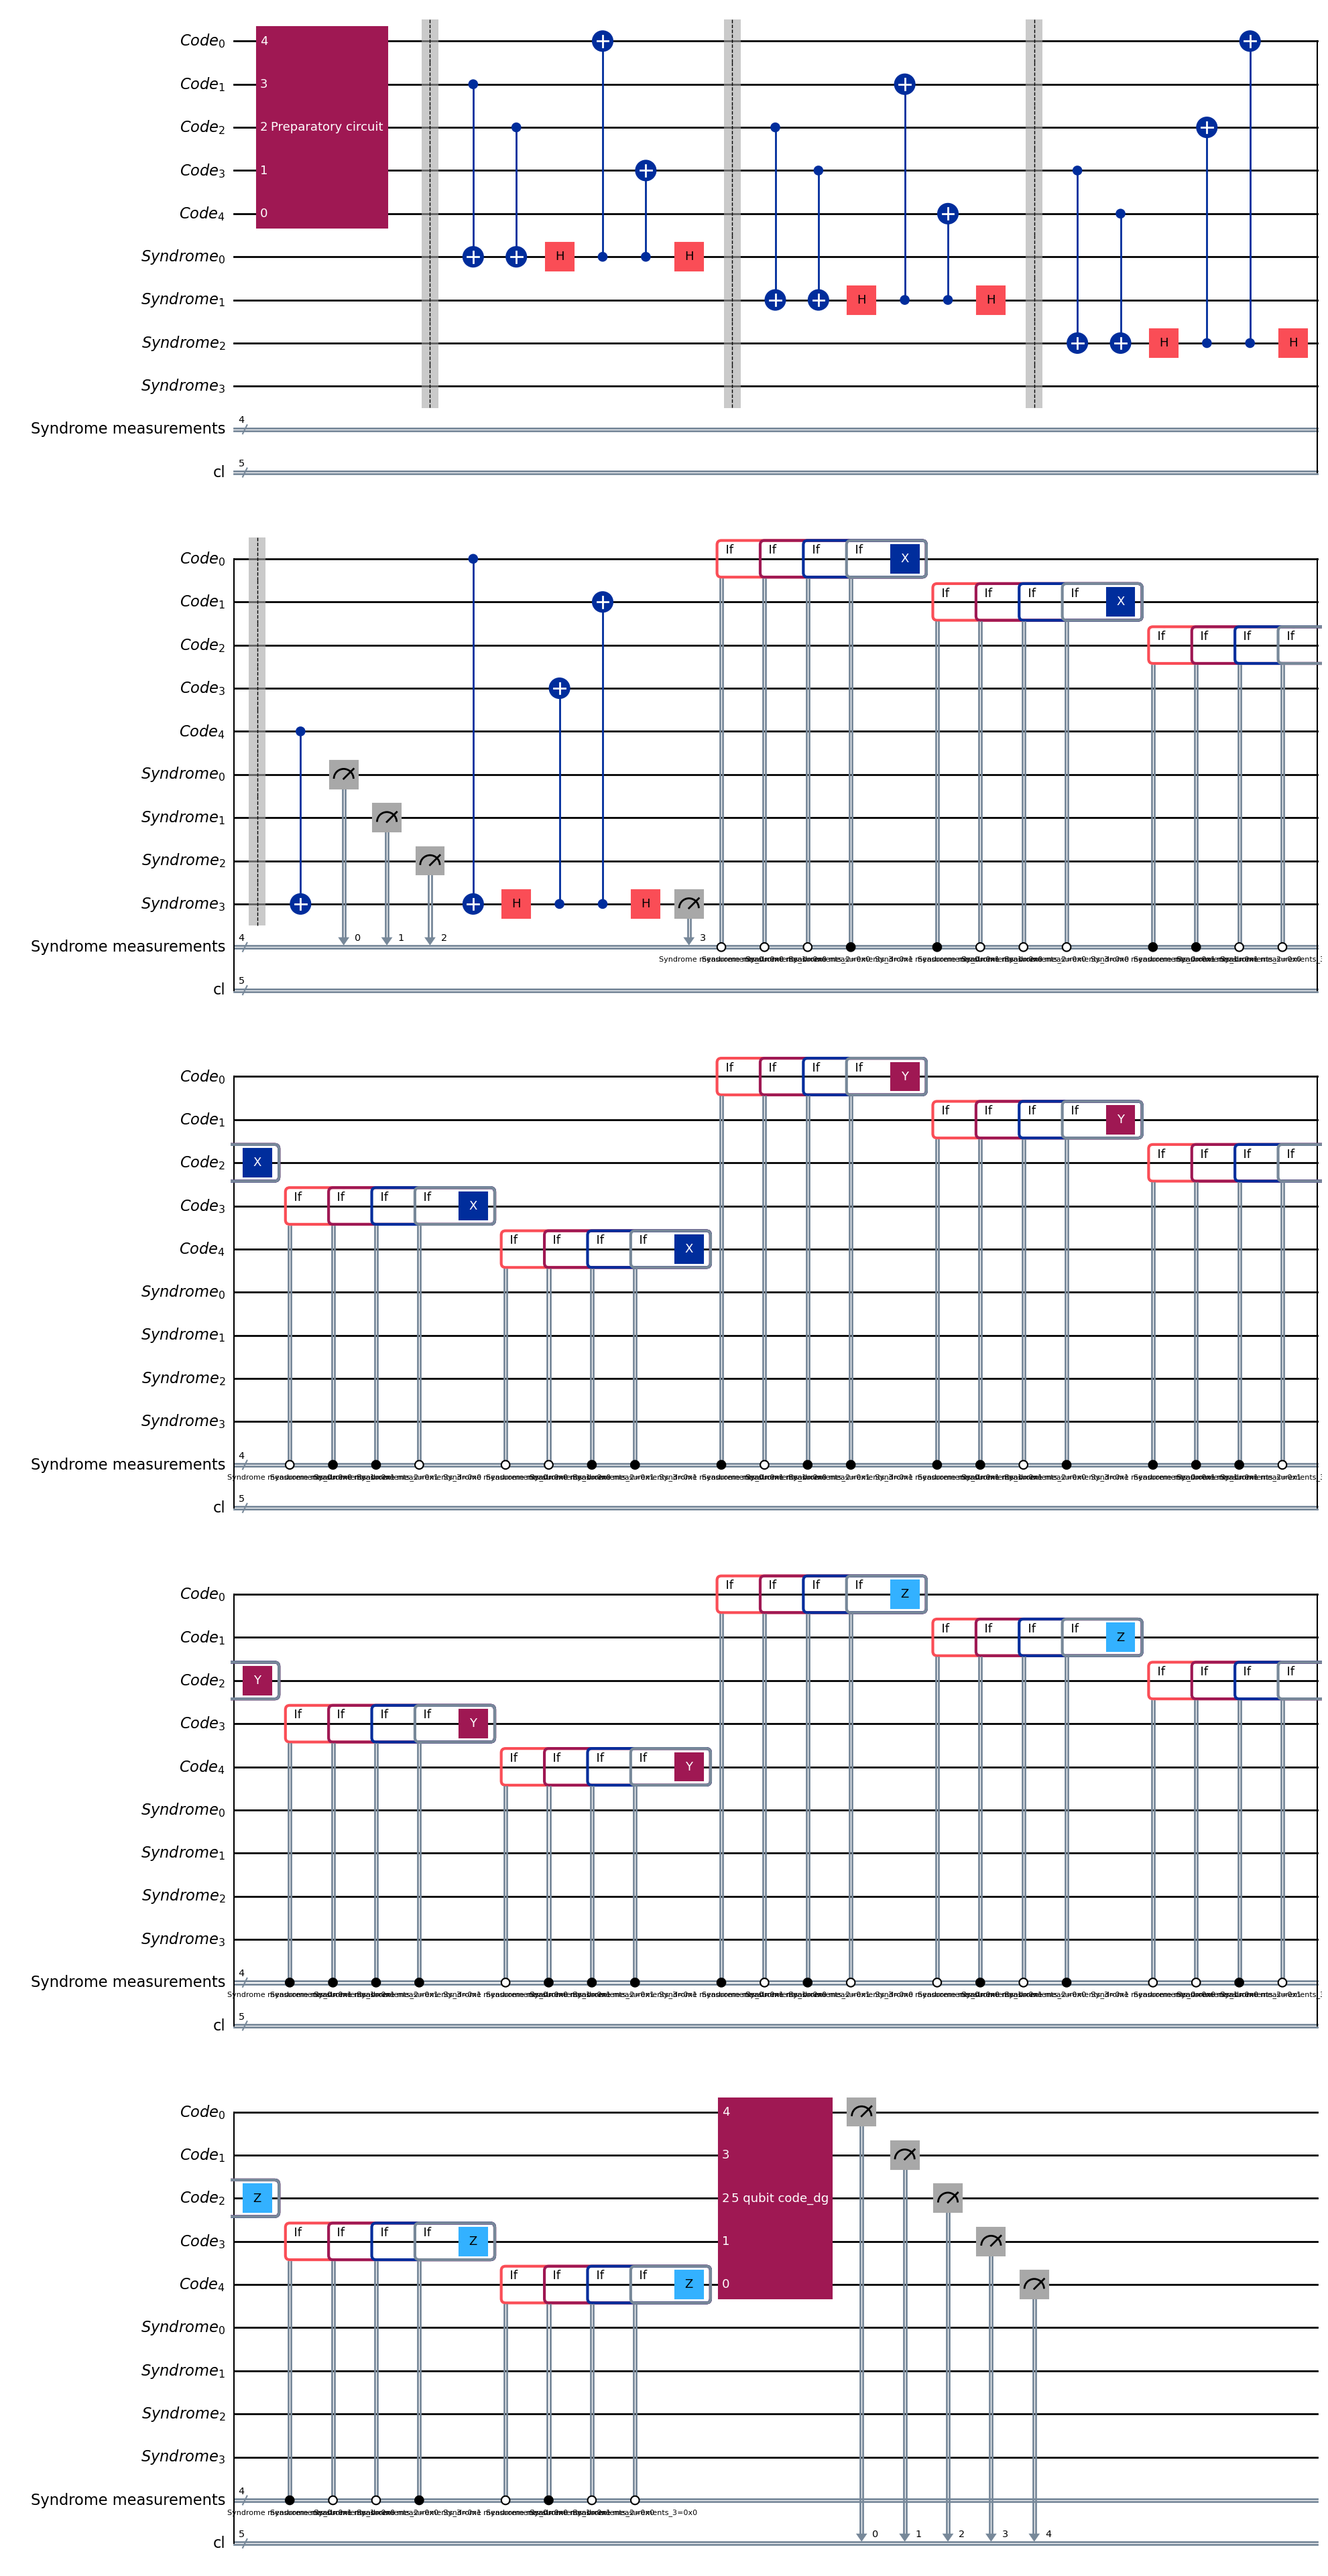

In [443]:
five_qubit_prep = logical_state_encoder(1).to_gate()
five_qubit_prep.label = "Preparatory circuit"

qubits_for_code = QuantumRegister(size=5,name="Code")
qubits_for_syndromes = AncillaRegister(size=4,name="Syndrome")
Syndrome_Measurements = ClassicalRegister(size=4,name="Syndrome measurements")
five_code_circuit = QuantumCircuit(qubits_for_code, qubits_for_syndromes, Syndrome_Measurements, name = "Five Qubit Code")

#We prepare a logical qubit using our preparatory circuit
five_code_circuit.compose(five_qubit_prep, qubits=[4,3,2,1,0], inplace=True)

#We now check each syndrome, going one at a time doing the X checks first, and then the Z checks.
#Each syndrome has X checks separated by 3 qubits and consecutive Z checks, allowing us to use a for loop to iterate through them

for i in range(4):
    five_code_circuit.barrier()
    five_code_circuit.cx(qubits_for_code[i+1],qubits_for_syndromes[i])
    five_code_circuit.cx(qubits_for_code[(i+2)%5],qubits_for_syndromes[i])
    five_code_circuit.h(qubits_for_syndromes[i])
    five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[i])
    five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[(i+3)%5])
    five_code_circuit.h(qubits_for_syndromes[i])
    

#We now measure the syndromes, and in doing so, identify any errors that have arisen.

five_code_circuit.measure(qubits_for_syndromes,Syndrome_Measurements)

# Now we correct errors using our dictionary of error_fixes
for item in error_fixes:
    with five_code_circuit.if_test((Syndrome_Measurements[0],(item[2])[0])):
        with five_code_circuit.if_test((Syndrome_Measurements[1],(item[2])[1])):
            with five_code_circuit.if_test((Syndrome_Measurements[2],(item[2])[2])):
                with five_code_circuit.if_test((Syndrome_Measurements[3],(item[2])[3])):
                    if item[0] == 'x':
                        five_code_circuit.x(item[1])
                    elif item[0] == 'y':
                        five_code_circuit.y(item[1])
                    elif item[0] == 'z':
                        five_code_circuit.z(item[1])
            

five_code_circuit.compose(five_qubit_prep.inverse(),qubits=[4,3,2,1,0],inplace=True)


#Now we measure the ending qubit to make sure that our error-correction worked.
qubit_measurements = ClassicalRegister(size=5,name="cl")
five_code_circuit.add_register(qubit_measurements)
five_code_circuit.measure(qubits_for_code,qubit_measurements)

five_code_circuit.draw(output="mpl")

We can now test our circuit to make sure that everything is working correctly. As we have introduced no errors at this point, our expected result is a zero in every qubit, which is, happily, what we get

In [444]:
simulator = AerSimulator()
compiled_circuit = transpile(five_code_circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=5000)

# Get the measurement counts
counts = job.result().get_counts()
counts

{'00000 0000': 5000}

# Testing the Circuit
We create a function which takes a boolean and an error probability, and runs the above circuit with the initial logical state and introduces single gate errors on each qubit with the given probability.

In [541]:
def five_code_checker(starting_state,error_prob):
    """
    This runs a 5 qubit error correcting code by encoding a given logical qubit, and then introducing a Pauli gate error with a given probability in every qubit

    Inputs
    ------
    starting_state (int): the encoded logical qubit. Must be 0 or 1
    error_prob (float): the probability that a given qubit has a single gate error. The probability that there are no errors is (1-error_prob)^5.

    Output
    ------
    This outputs a qiskit circuit encoding the logical qubit, introduces errors, checks for errors, fixes errors, and then rests the qubits back to 0.

    """

    
    qubits_for_code = QuantumRegister(size=5,name="Code")
    qubits_for_syndromes = AncillaRegister(size=4,name="Syndrome")
    Syndrome_Measurements = ClassicalRegister(size=4,name="Syndrome measurements")
    five_code_circuit = QuantumCircuit(qubits_for_code, qubits_for_syndromes, Syndrome_Measurements, name = "Five Qubit Code")
    
    #We prepare a logical qubit using our preparatory circuit
    five_qubit_prep = logical_state_encoder(starting_state).to_gate()
    five_qubit_prep.label = "Preparatory circuit"
    five_code_circuit.compose(five_qubit_prep, qubits=[4,3,2,1,0], inplace=True)
    
    #We now introduce a random error
    five_code_circuit.barrier()
    five_code_circuit.compose(error_channel(5,error_prob),inplace=True)
    
    #We now check each syndrome, going one at a time doing the X checks first, and then the Z checks.
    #Each syndrome has X checks separated by 3 qubits and consecutive Z checks, allowing us to use a for loop to iterate through them
    
    for i in range(4):
        five_code_circuit.barrier()
        five_code_circuit.cx(qubits_for_code[i+1],qubits_for_syndromes[i])
        five_code_circuit.cx(qubits_for_code[(i+2)%5],qubits_for_syndromes[i])
        five_code_circuit.h(qubits_for_syndromes[i])
        five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[i])
        five_code_circuit.cx(qubits_for_syndromes[i],qubits_for_code[(i+3)%5])
        five_code_circuit.h(qubits_for_syndromes[i])
        
    
    #We now measure the syndromes, and in doing so, identify any errors that have arisen.
    
    five_code_circuit.measure(qubits_for_syndromes,Syndrome_Measurements)
    
    # Now we correct errors using our dictionary of error_fixes
    for item in error_fixes:
        with five_code_circuit.if_test((Syndrome_Measurements[0],(item[2])[0])):
            with five_code_circuit.if_test((Syndrome_Measurements[1],(item[2])[1])):
                with five_code_circuit.if_test((Syndrome_Measurements[2],(item[2])[2])):
                    with five_code_circuit.if_test((Syndrome_Measurements[3],(item[2])[3])):
                        if item[0] == 'x':
                            five_code_circuit.x(item[1])
                        elif item[0] == 'y':
                            five_code_circuit.y(item[1])
                        elif item[0] == 'z':
                            five_code_circuit.z(item[1])
                
    
    five_code_circuit.compose(five_qubit_prep.inverse(),qubits=[4,3,2,1,0],inplace=True)
    
    
    #Now we measure the ending qubit to make sure that our error-correction worked.
    qubit_measurements = ClassicalRegister(size=5,name="cl")
    five_code_circuit.add_register(qubit_measurements)
    five_code_circuit.measure(qubits_for_code,qubit_measurements)
    return five_code_circuit

# Measuring Success Probability

In order to measure the probability of successfully correcting an error, we need to run the above function many times, logging whether the the code has successfully been corrected

In [542]:
def is_correct(starting_state, error_prob):
    """
    This tells us whether a given iteration of our circuit has successfully corrected any errors introduced

    Inputs
    ------
    starting_state (int): the encoded logical qubit. Must be 0 or 1
    error_prob (float): the probability that a given qubit has a single gate error. The probability that there are no errors is (1-error_prob)^5.

    Outputs
    ------
    True if the error has been corrected, False otherwise.
    """
    simulator = AerSimulator()
    compiled_circuit = transpile(five_code_checker(starting_state,error_prob), simulator)

    # Run the circuit
    job = simulator.run(compiled_circuit, shots=1)

    counts = job.result().get_counts()

    if (list(counts.keys())[0])[0:5] == '00000':
        return True
    else:
        return False

Using this function, we can collect data for a given error probability and determine how often the code is successfully transmitted

In [523]:
def simulation_success_rate(n, starting_state, error_prob):
    """
    This function allows us to test how often our code can successfully correct for any errors that arose at a given error probability rate

    Inputs
    ------
    n (int): number of attempts to run
    starting_state (int): the encoded logical qubit. Must be 0 or 1
    error_prob (float): The probability that a given qubit has a single gate error. The probability that there are no errors is (1-error_prob)^5.

    Outputs
    -------
    successes/attempts (float): The number of times that any errors introduced were successfully corrected.
    """
    attempts = 0
    successes = 0
    while attempts < n:
        if is_correct(starting_state, error_prob):
            successes += 1
        attempts += 1
    return successes/attempts

Because we have limited time in our lives, we will only test the success rate for batches of 100 attempts at each given error rate. To compensate for this relatively low batch size, we run it frequently, at 50 separate error rates. Note that we shouldn't necessarily expect the success rate to go to zero as the error rate increases to 1. This is because as more and more errors are introduced, the possibility that they are obscured by each other is increased (for instance, if an X-gate error is introduced in every qubit)

In [555]:
n = 50
xvals = np.linspace(0, 1, n)
yvals = []
for x in xvals:
    y = simulation_success_rate(150, 0, x)
    yvals.append(y)
yvals = np.asarray(yvals)

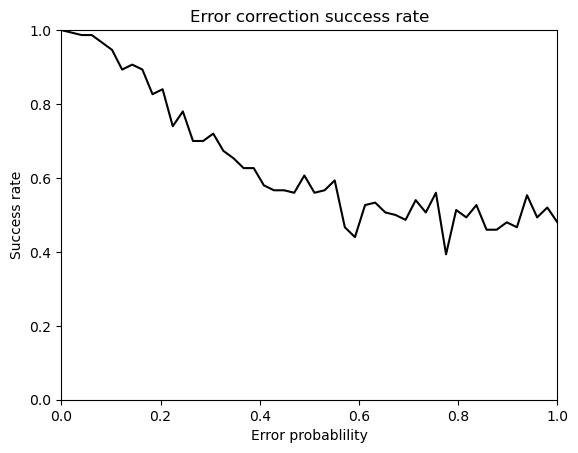

In [556]:
%matplotlib inline
fig = plt.figure()
plt.plot(xvals, yvals, linestyle='-', color='k')
plt.xlabel('Error probablility')
plt.ylabel('Success rate')
plt.title('Error correction success rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [552]:
%%time
simulation_success_rate(150,0,0.5)

CPU times: total: 41.2 s
Wall time: 42.3 s


0.5866666666666667

In [550]:
yvals

array([1.  , 1.  , 0.99, 0.98, 0.96, 0.97, 0.93, 0.94, 0.91, 0.87, 0.88,
       0.79, 0.69, 0.8 , 0.78, 0.76, 0.66, 0.67, 0.67, 0.6 , 0.52, 0.58,
       0.5 , 0.57, 0.62, 0.6 , 0.62, 0.53, 0.48, 0.41, 0.51, 0.48, 0.47,
       0.55, 0.4 , 0.42, 0.56, 0.49, 0.51, 0.43, 0.49, 0.45, 0.48, 0.55,
       0.56, 0.5 , 0.57, 0.48, 0.48, 0.43])